# Classify organs present in ultrasound images

In [2]:
import os
import numpy
from fastai import *
from fastai.vision import *

#torch.cuda.set_device(1)

## Data import

In [6]:
valid_frac = 0.2
#seed_set = 100

In [7]:
data_path1 = "data/Output_organ/"
data1 = ImageDataBunch.from_folder(data_path1, valid_pct=valid_frac, size =224, ds_tfms=get_transforms()).normalize(imagenet_stats)

In [6]:
data1

ImageDataBunch;

Train: LabelList (1294 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1.1,1.1,1.1,1.1,1.1
Path: data/Output_organ;

Valid: LabelList (323 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1.6,1.5,1.11,1.4,1.4
Path: data/Output_organ;

Test: None

In [8]:
data_path2 = "data/Organ_Liver_Others/"
data2 = ImageDataBunch.from_folder(data_path2, valid_pct=valid_frac, size =224, ds_tfms=get_transforms()).normalize(imagenet_stats)

In [8]:
data2

ImageDataBunch;

Train: LabelList (1294 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Liver,Liver,Liver,Liver,Liver
Path: data/Organ_Liver_Others;

Valid: LabelList (323 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Others,Liver,Others,Others,Liver
Path: data/Organ_Liver_Others;

Test: None

## [Case1] Transfer Learning - train head

In [14]:
learn1 = cnn_learner(data2, models.resnet34, metrics=[accuracy,AUROC()])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


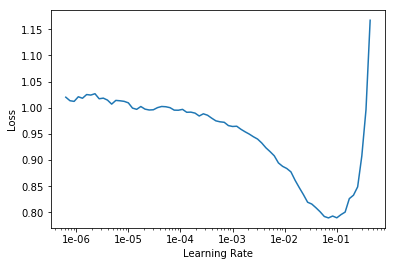

In [15]:
learn1.lr_find()
learn1.recorder.plot()

In [16]:
lr1 = 2e-2

In [17]:
callbacks_opt1 = [callbacks.SaveModelCallback(learn1,
                                             monitor='accuracy',
                                             every='improvement',
                                             name='best_b_accuracy_resnet34')]

In [18]:
learn1.fit(10, lr1, callbacks=callbacks_opt1)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.799964,0.688229,0.814241,0.661820,01:24
1,0.655472,0.438346,0.811145,0.763258,01:24
2,0.566868,0.471307,0.767802,0.803897,01:24
3,0.515082,0.452413,0.789474,0.745795,01:25
4,0.471149,0.430932,0.845201,0.813495,01:24
5,0.432582,0.501238,0.829721,0.724929,01:25
6,0.404946,0.391320,0.817337,0.808648,01:32
7,0.375718,0.417673,0.811145,0.793047,01:26
8,0.377720,0.382816,0.808050,0.831953,01:23
9,0.361296,0.397538,0.839009,0.794845,01:23


Better model found at epoch 0 with accuracy value: 0.8142414689064026.
Better model found at epoch 4 with accuracy value: 0.8452012538909912.


In [19]:
learn1.load('best_b_accuracy_resnet34');
learn1.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
______________________________________________________________

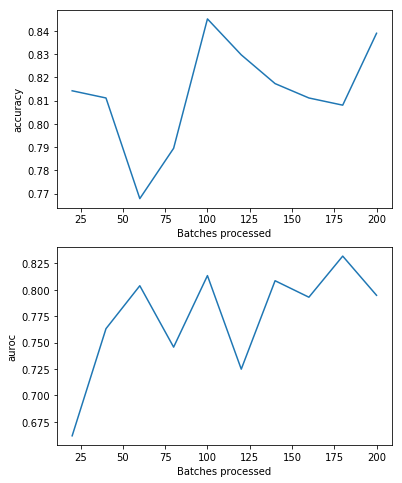

In [20]:
learn1.recorder.plot_metrics()

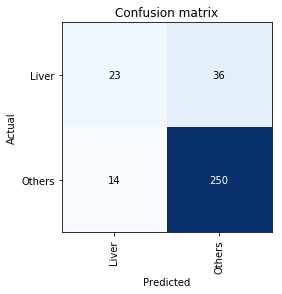

In [21]:
interp1 = ClassificationInterpretation.from_learner(learn1)
interp1.plot_confusion_matrix(normalize=False, figsize=(4, 4))

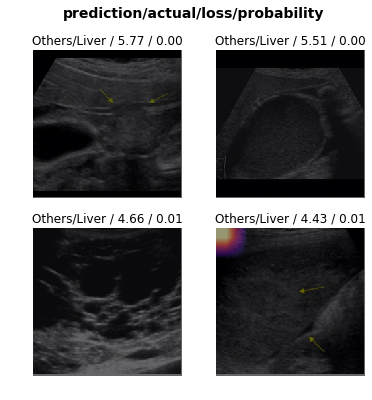

In [44]:
interp1.plot_top_losses(4, figsize=(6, 6))

309 misclassified samples over 323 samples in the validation set.


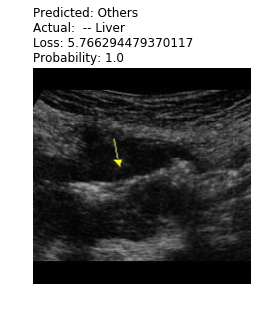

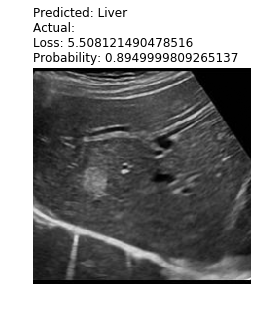

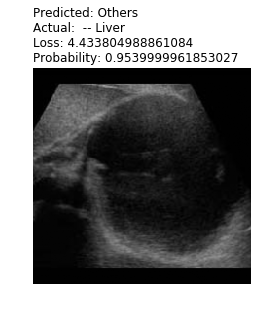

In [25]:
interp1.plot_multi_top_losses(3, figsize=(4, 4))

## [Case2] Fine Tuning - train the whole model

In [26]:
learn2 = cnn_learner(data2, models.resnet34, metrics=[accuracy,AUROC()])

In [27]:
learn2.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


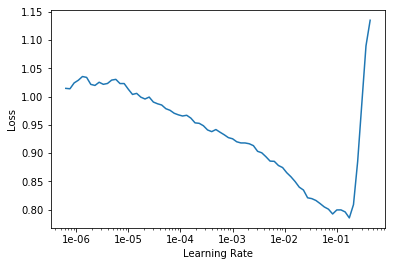

In [28]:
learn2.lr_find()
learn2.recorder.plot()

In [29]:
lr_max2 = 4e-02

In [30]:
callbacks_opt2 = [callbacks.SaveModelCallback(learn2,
                                             monitor='accuracy',
                                             every='improvement',
                                             name='best_ft_accuracy_resnet34')]

In [31]:
learn2.fit(10, slice(lr_max2/5,lr_max2), callbacks=callbacks_opt2)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,1.108745,217.349167,0.213622,0.519838,02:01
1,1.005031,0.788347,0.817337,0.472554,01:55
2,0.896614,0.595474,0.817337,0.620634,02:00
3,0.848285,0.563045,0.817337,0.670294,03:23
4,0.759971,0.648544,0.817337,0.752472,02:28
5,0.692153,0.500346,0.817337,0.661691,01:56
6,0.682517,0.601442,0.817337,0.589914,01:55
7,0.652125,0.580705,0.752322,0.713823,01:57
8,0.665856,0.645051,0.817337,0.645898,01:54
9,0.647074,0.442310,0.817337,0.727497,01:56


Better model found at epoch 0 with accuracy value: 0.2136222869157791.
Better model found at epoch 1 with accuracy value: 0.8173374533653259.


In [36]:
learn2.load('best_ft_accuracy_resnet34');
learn2.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
______________________________________________________________

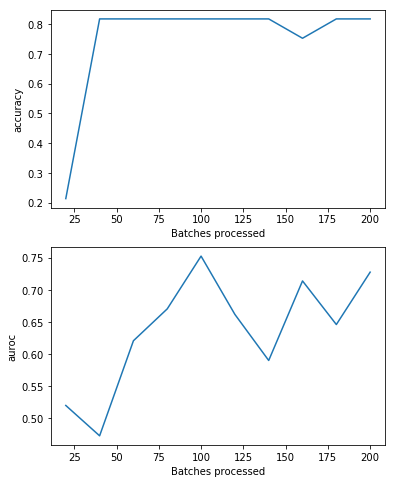

In [37]:
learn2.recorder.plot_metrics() 

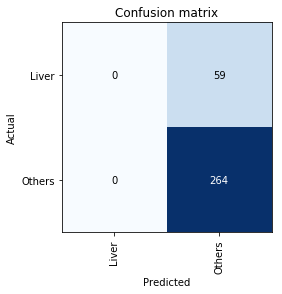

In [38]:
interp2 = ClassificationInterpretation.from_learner(learn2)
interp2.plot_confusion_matrix(normalize=False, figsize=(4, 4))

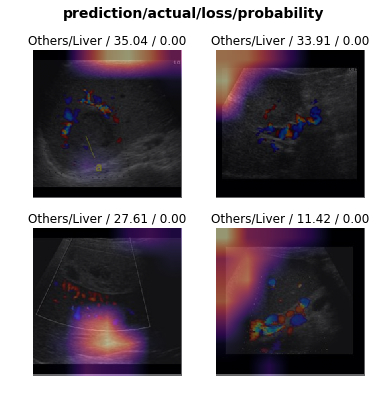

In [43]:
interp2.plot_top_losses(4, figsize=(6, 6))

323 misclassified samples over 323 samples in the validation set.


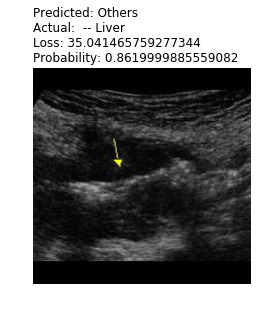

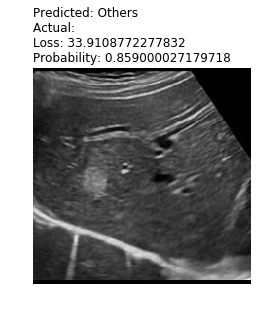

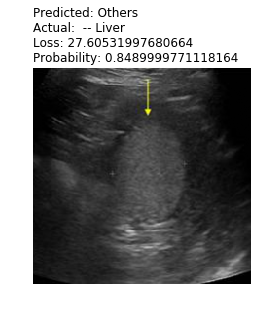

In [40]:
interp2.plot_multi_top_losses(3, figsize=(4, 4))

In [41]:
#freeze bottom layer
learn2.freeze()

## [Case3] Transfer Learning of customised pretrained model

### Fine tuning with dataset1

In [9]:
learn3 = cnn_learner(data1, models.resnet34, metrics=[accuracy,AUROC()])

In [10]:
learn3.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


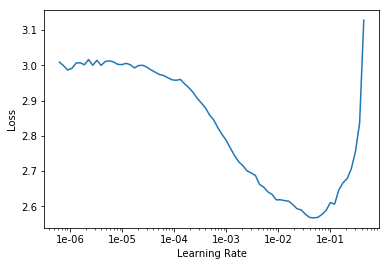

In [34]:
learn3.lr_find()
learn3.recorder.plot()

In [11]:
lr_max3= 1e-03

In [48]:
callbacks_opt3 = [callbacks.SaveModelCallback(learn3,
                                             monitor='accuracy',
                                             every='improvement',
                                             name='best_accuracy_unfreeze_resnet34')]

In [49]:
learn3.fit(10, slice(lr_max3/5,lr_max3), callbacks=callbacks_opt3)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,2.346289,2.043552,0.424149,0.461787,01:56
1,1.983165,1.912622,0.473684,0.487097,01:55
2,1.783658,1.775663,0.452012,0.546898,01:55
3,1.573286,1.665076,0.501548,0.421340,01:54
4,1.396750,1.692353,0.513932,0.600000,01:57
5,1.274635,1.726048,0.504644,0.647395,01:57
6,1.134094,1.901087,0.486068,0.602730,01:58
7,1.019783,1.897463,0.464396,0.527792,01:57
8,0.911705,1.862445,0.520124,0.678908,01:57
9,0.830262,1.830019,0.520124,0.540199,01:57


Better model found at epoch 0 with accuracy value: 0.4241486191749573.
Better model found at epoch 1 with accuracy value: 0.4736842215061188.
Better model found at epoch 3 with accuracy value: 0.5015479922294617.
Better model found at epoch 4 with accuracy value: 0.5139318704605103.
Better model found at epoch 8 with accuracy value: 0.5201238393783569.


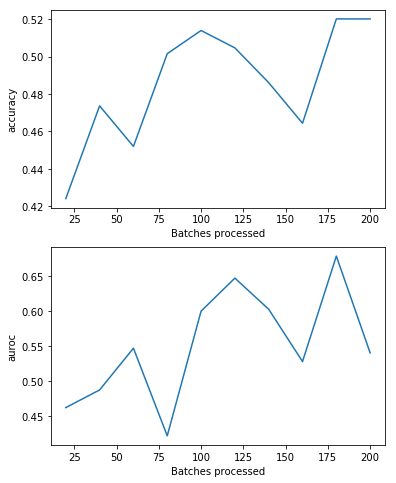

In [50]:
learn3.recorder.plot_metrics()

In [12]:
learn3.load('best_accuracy_unfreeze_resnet34');
learn3.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
______________________________________________________________

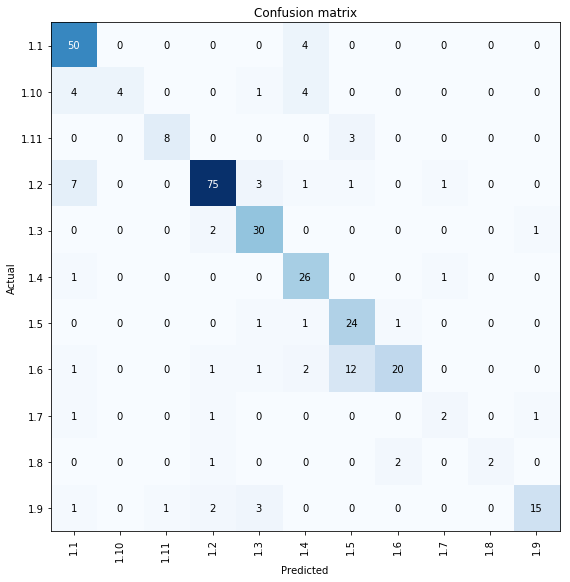

In [14]:
interp3 = ClassificationInterpretation.from_learner(learn3)
interp3.plot_confusion_matrix(normalize=False, figsize=(8, 8))

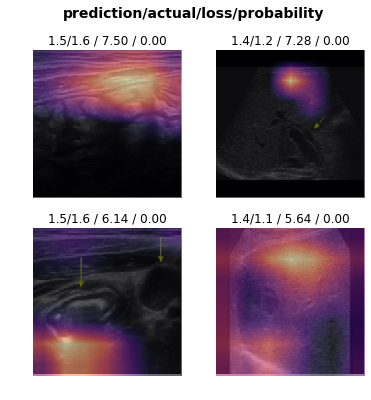

In [16]:
interp3.plot_top_losses(4, figsize=(6, 6))

308 misclassified samples over 323 samples in the validation set.


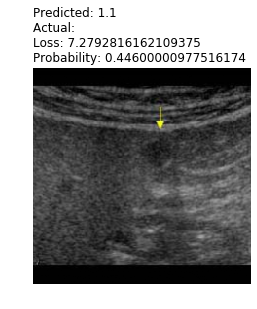

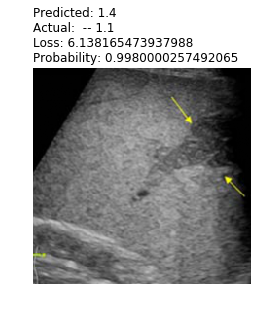

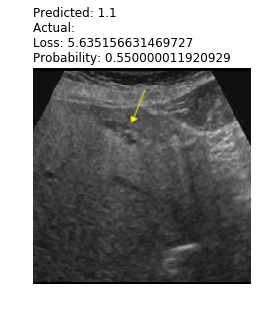

In [17]:
interp3.plot_multi_top_losses(3, figsize=(4, 4))

In [18]:
learn3.freeze()

### Transfer Learning with dataset2

In [19]:
learn4 = cnn_learner(data2, models.resnet34, metrics=[accuracy,AUROC()])

In [21]:
learn_temp = learn3.load('best_accuracy_unfreeze_resnet34')

In [22]:
learn4.model[0].load_state_dict(learn_temp.model[0].state_dict())

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [23]:
print(learn4.model[0])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [24]:
print(learn4.model[1])

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=2, bias=True)
)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


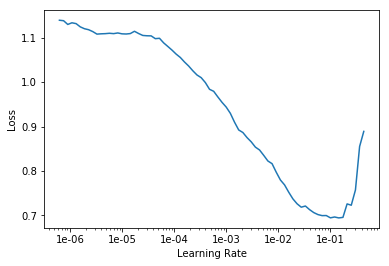

In [25]:
learn4.lr_find()
learn4.recorder.plot()

In [26]:
lr4 = 8e-03

In [27]:
callbacks_opt4 = [callbacks.SaveModelCallback(learn4,
                                             monitor='accuracy',
                                             every='improvement',
                                             name='best_accuracy_tl_resnet34')]

In [29]:
learn4.fit(10, lr4, callbacks=callbacks_opt4)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.432373,0.256630,0.904025,0.923928,01:25
1,0.338503,0.205789,0.919505,0.950377,01:21
2,0.294898,0.383822,0.860681,0.909344,01:22
3,0.262860,0.342313,0.854489,0.942529,01:24
4,0.245976,0.268438,0.897833,0.961253,01:25
5,0.226499,0.699820,0.835913,0.813497,01:23
6,0.210332,0.602424,0.835913,0.879619,01:22
7,0.204420,0.275880,0.904025,0.940984,01:22
8,0.194649,0.527957,0.863777,0.899024,01:24
9,0.196427,0.371219,0.873065,0.880855,01:25


Better model found at epoch 0 with accuracy value: 0.9040247797966003.
Better model found at epoch 1 with accuracy value: 0.9195046424865723.


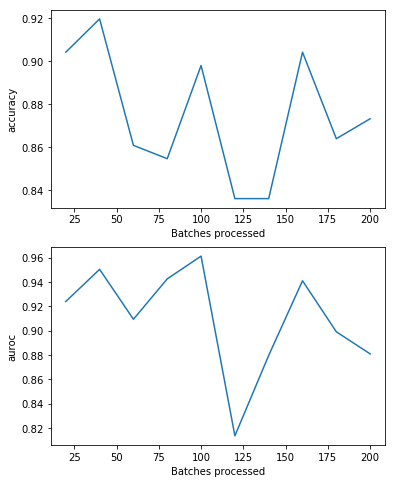

In [30]:
learn4.recorder.plot_metrics()

In [31]:
learn4.load('best_accuracy_tl_resnet34');
learn4.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
______________________________________________________________

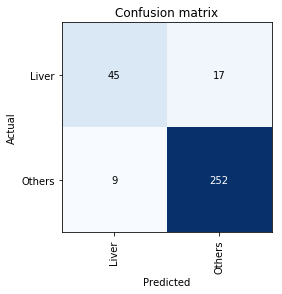

In [32]:
interp4 = ClassificationInterpretation.from_learner(learn4)
interp4.plot_confusion_matrix(normalize=False, figsize=(4, 4))

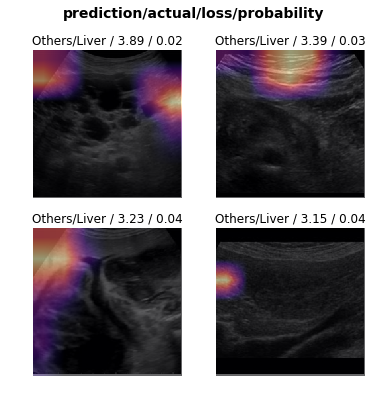

In [34]:
interp4.plot_top_losses(4, figsize=(6, 6))

314 misclassified samples over 323 samples in the validation set.


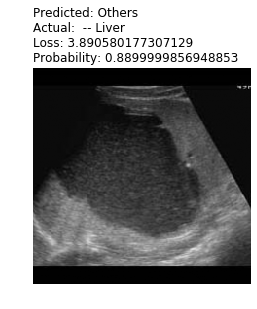

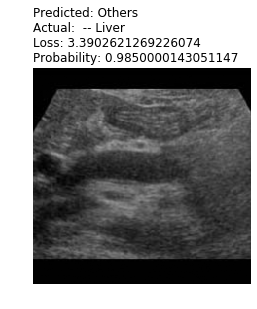

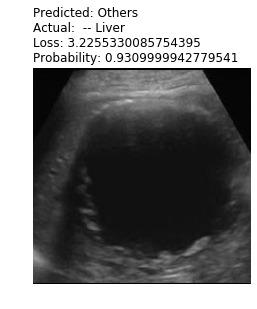

In [36]:
interp4.plot_multi_top_losses(3, figsize=(4, 4))

## Prediction

In [ ]:
img = Image.open(path)

In [ ]:
img

In [ ]:
learn1.predict(img)

In [ ]:
learn2.predict(img)

In [ ]:
learn4.predict(img)